# Plot zonal annual mean NOy

---

Create date: 2025-08-19

Plot zonal mean of NOy from Ozone investigation [Ticket link](https://code.metoffice.gov.uk/trac/UKESM/wiki/1016_Simulations)


In [1]:
import yaml
import iris
import xarray as xr
from ncdata.iris_xarray import cubes_to_xarray
import sys
import matplotlib.pyplot as plt

# modules from this directory

# local module elsewhere

sys.path.append("/home/users/vs480/explore_cmip6")
import src.const as CONST
from src.util.STASH_fields_defs import UKCA_callback

# from src.util.load_data import *

In [2]:
# Load config
with open("config.yaml") as f:
    config = yaml.safe_load(f)

In [3]:
def generate_dataset_file_paths(
    data_root_dir: str, dataset_suites: dict[str, str], stashes: list[str]
):
    """
    Create dictionary of lists of file paths for each suite.

    Parameters
    ----------
    data_root_dir : str
        Root directory where data is stored.
    dataset_suites : dict of str
        Mapping of dataset names to Rose suite IDs. e.g. u-ab123
    stashes : list of str
        List of stash items. e.g. 50001

    Returns
    -------
    dict of str to list of str
        Dictionary mapping dataset names to lists of file paths.

    """
    paths = {}
    for exp, suite in dataset_suites.items():
        paths[exp] = [f"{data_root_dir}/{suite}_apy.pp_{v}/*.pp" for v in stashes]
    return paths

In [ ]:
def load_xr_from_pp(
    paths: list[str],
    rename_coords: bool = False,
    rename_dict: dict = None,
):
    """
    Load a list of PP files into an xarray.Dataset .

    Parameters
    ----------
    paths : list of str
        List of file paths to load. May contain wildcard (*)
    rename_coords : bool, optional
        If True, rename coordinates using `rename_dict`. Default is False.
    rename_dict : dict, optional
        Dictionary mapping original coordinate names to new names. If None and renaming is requested,
        a default mapping for 'latitude', 'longitude', and 'model_level_number' is used.

    Returns
    -------
    xarray.Dataset
        The loaded dataset with coordinates optionally renamed.
    """

    # Check if paths is set
    if not paths:
        raise FileNotFoundError("No file paths provided to load_xr_from_pp.")

    # ensure dataset-level and variable-level attributes loaded correctly
    iris.FUTURE.save_split_attrs = True

    iris_cube = iris.load(paths, callback=UKCA_callback)

    ds = cubes_to_xarray(iris_cube)
    if rename_coords:
        if rename_dict is None:
            rename_dict = {
                "latitude": "lat",
                "longitude": "lon",
                "model_level_number": "lev",
            }

        ds = ds.rename(rename_dict)

    return ds


def load_multiple_exps(
    config: dict,
    exp_subset: list[str] = None,
    stashes_subset: list[str] = None,
    rename_coords: bool = False,
):
    """
    Load multiple experiments' datasets from pp files as xarray objects based on configuration and optional subsets.

    Parameters
    ----------
    config : dict
        Configuration dictionary containing 'dataset_suites', 'stashes', and 'pp_root_dir'.
    exp_subset : list of str, optional
        List of experiment keys to load. If None, all experiments in config['dataset_suites'] are loaded.
    stashes_subset : list of str, optional
        List of stash codes to load. If None, all stashes in config['stashes'] are loaded.
    rename_coords : bool, optional
        If True, rename coordinates using `rename_dict`. Default is False.
    Returns
    -------
    dict of str to xarray.Dataset
        Dictionary mapping experiment names to loaded xarray datasets.
    """

    if exp_subset is None:
        datasets_load = config["dataset_suites"]
    else:
        datasets_load = {
            exp: config["dataset_suites"][exp]["rose-suite"]
            for exp in exp_subset
            if exp in config["dataset_suites"]
        }

    if stashes_subset is None:
        stashes_load = config["stashes"]
    else:
        stashes_load = stashes_subset

    dataset_paths = generate_dataset_file_paths(
        data_root_dir=config["pp_root_dir"],
        dataset_suites=datasets_load,
        stashes=stashes_load,
    )

    datasets = {
        exp: load_xr_from_pp(paths, rename_coords=rename_coords)
        for exp, paths in dataset_paths.items()
    }

    return datasets

## Load data


In [71]:
# Subset of values to load
exp_subset = [
    # "e1-st2-hc",
    # "e2-st2-hc",
    # "e2-st2+lnox4-hc",
    # "e2-st2+ipl8all-hc",
    # "e2-st2+ipl8chemtracer-hc",
]

stashes_subset = [
    # "34001",
    # "34002",
    # "34996",
    # "34003",
    "34005",
    # "50062",
]

datasets = load_multiple_exps(config, exp_subset, stashes_subset)

OSError: One or more of the files specified did not exist:
    * "/work/scratch-pw2/vs480/pp_files/u-dq731_apy.pp_34005/*.pp" didn't match any files

## Plot NO


In [6]:
def create_custom_subplots(
    fig_width, widths_subplot, heights_subplot, exclude_bottom_rows: int = 0
):

    fig = plt.figure(figsize=(fig_width, 0.5 * fig_width))

    nrow = len(heights_subplot)
    ncol = len(widths_subplot)

    gs = fig.add_gridspec(
        nrow, ncol, width_ratios=widths_subplot, height_ratios=heights_subplot
    )

    if nrow - exclude_bottom_rows < 0:
        raise ValueError("nrow < 0")

    axs = [
        fig.add_subplot(gs[i, j])
        for i in range(nrow - exclude_bottom_rows)
        for j in range(ncol)
    ]

    return fig, axs, gs, nrow, ncol

In [ ]:
zonal_mean_ppb = {e: xr.Dataset() for e in datasets.keys()}

molar_masses = {
    "no": CONST.M_NO,
    "no2": CONST.M_NO2,
    "no3": CONST.M_NO3,
    "o3": CONST.M_O3,
    "hono2": CONST.M_HONO2,
    "mass_fraction_of_nitric_acid_in_air": CONST.M_HONO2,
}

for exp in zonal_mean_ppb.keys():
    # for species in ["no", "no2", "no3", "o3"]:
    for species in ["mass_fraction_of_nitric_acid_in_air"]:
        zonal_mean_ppb[exp][species] = (
            datasets[exp][species]
            .sel(time=slice("1865-01-01", "1895-01-01"))  # after spin-up
            .mean(dim=["lon", "time"])
            .load()
            / molar_masses[species]
            * CONST.M_AIR
            * 1e9
        )

In [8]:
for exp in zonal_mean_ppb.keys():
    zonal_mean_ppb[exp]["noy"] = (
        zonal_mean_ppb[exp]["no"]
        + zonal_mean_ppb[exp]["no2"]
        + zonal_mean_ppb[exp]["no3"]
    )

In [41]:
def plot_zonal_mean(zonal_mean_ppb, species, vmax, diff_vmax):

    fig, axs, gs, nrow, ncol = create_custom_subplots(
        fig_width=12,
        widths_subplot=[1, 1, 1, 1, 1],
        heights_subplot=[1, 1, 0.05, 0.05],
        exclude_bottom_rows=2,
    )

    for i, exp in enumerate(zonal_mean_ppb.keys()):
        ax = axs[i]
        d_plot = zonal_mean_ppb[exp][species]
        heatmap = d_plot.plot(
            ax=ax,
            x="lat",
            y="level_height",
            add_colorbar=False,
            vmax=vmax,
            vmin=0,
            cmap=plt.cm.BuPu,
            levels=17,
            extend="max",
        )

        ax.set_title(exp)

    for i, exp in enumerate(zonal_mean_ppb.keys()):
        ax = axs[i + 5]
        d_plot = (
            (zonal_mean_ppb[exp][species] - zonal_mean_ppb["e1-st2-hc"][species])
            / zonal_mean_ppb["e1-st2-hc"][species]
            * 100
        )
        heatmap_diff = d_plot.plot(
            ax=ax,
            x="lat",
            y="level_height",
            add_colorbar=False,
            vmax=diff_vmax,
            vmin=-diff_vmax,
            cmap=plt.cm.RdBu_r,
            levels=61,
            extend="both",
        )

        ax.set_title(exp)

    for ax in axs:
        ax.set_ylim(0, 70000)
        ax.set_yticks(range(0, 70001, 10000))
        yticks = ax.get_yticks()
        ax.set_yticklabels([f"{int(y/1000)}" for y in yticks])
        ax.set_ylabel("")
        ax.set_xticks(range(-90, 91, 30))
        ax.set_xlabel("")

    for ax in axs[ncol:]:
        ax.set_xlabel("Latitude")

    for ax in axs[::ncol]:
        ax.set_ylabel("Height (km)")

    clb_ax = fig.add_subplot(gs[-2, :])
    clb = fig.colorbar(
        heatmap,
        cax=clb_ax,
        extend="max",
        orientation="horizontal",
    )
    clb.ax.set_xlabel(f"{species.upper()} (ppb)")

    clb_ax = fig.add_subplot(gs[-1, :])
    clb = fig.colorbar(
        heatmap_diff,
        cax=clb_ax,
        extend="both",
        orientation="horizontal",
    )
    clb.ax.set_xlabel(f"$\Delta${species.upper()} (%)")

    axs[5].remove()

    fig.tight_layout()

    return fig, axs

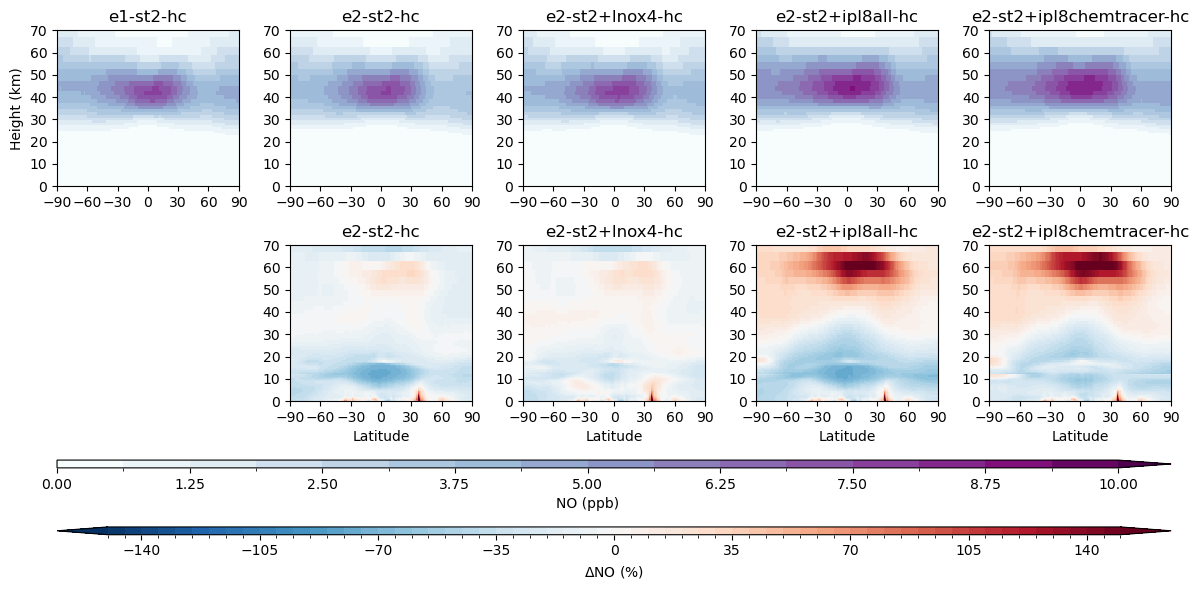

In [45]:
fig, ax = plot_zonal_mean(
    zonal_mean_ppb=zonal_mean_ppb,
    species="no",
    vmax=10,
    diff_vmax=150,
)

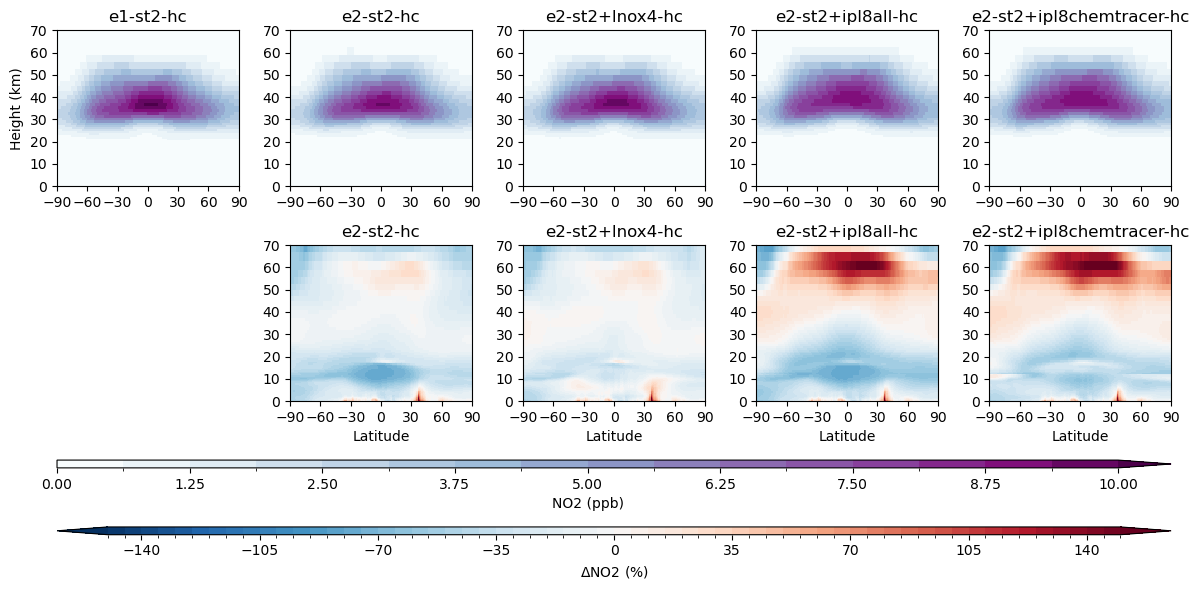

In [48]:
fig, ax = plot_zonal_mean(
    zonal_mean_ppb=zonal_mean_ppb,
    species="no2",
    vmax=10,
    diff_vmax=150,
)

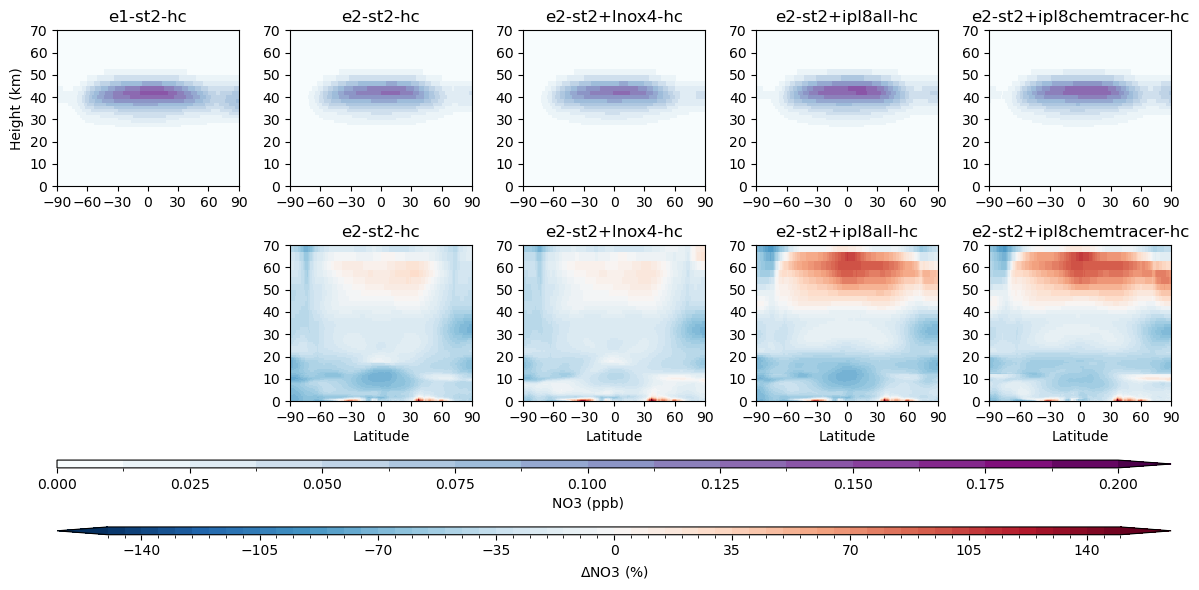

In [43]:
fig, ax = plot_zonal_mean(
    zonal_mean_ppb=zonal_mean_ppb,
    species="no3",
    vmax=0.2,
    diff_vmax=150,
)

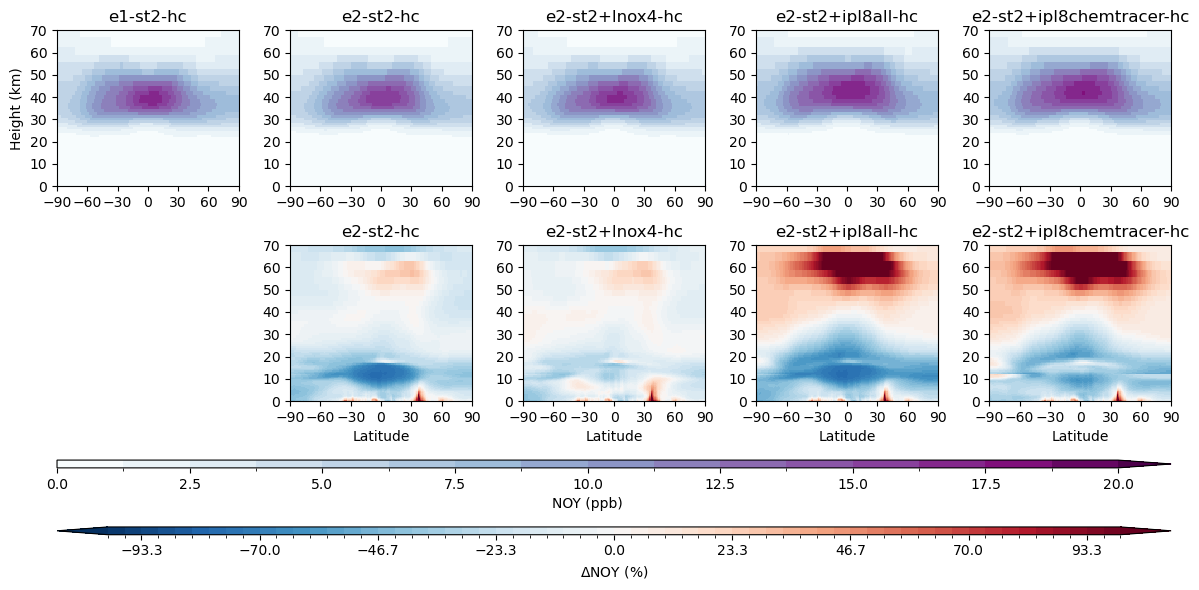

In [46]:
fig, ax = plot_zonal_mean(
    zonal_mean_ppb=zonal_mean_ppb,
    species="noy",
    vmax=20,
    diff_vmax=100,
)

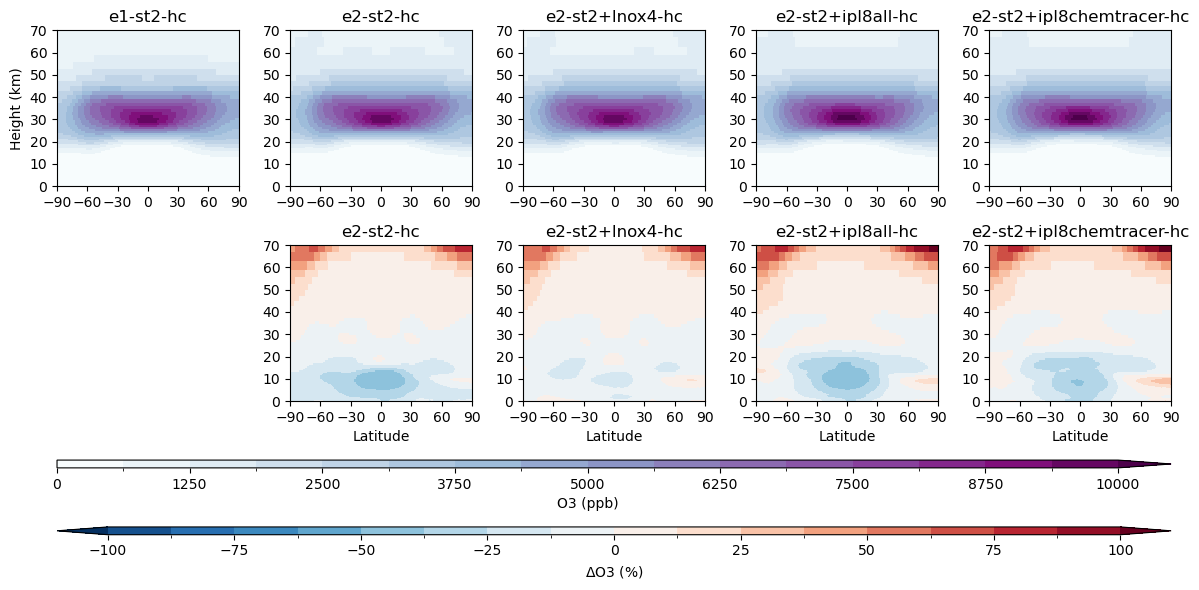

In [31]:
fig, ax = plot_zonal_mean(
    zonal_mean_ppb=zonal_mean_ppb,
    species="o3",
    vmax=10000,
    diff_vmax=100,
)

In [ ]:
datasets["e1-st2-hc"]

<xarray.Dataset>
Dimensions:                              (time: 45, lev: 85, lat: 144,
                                          lon: 192, bnds: 2)
Coordinates:
  * time                                 (time) object 1851-06-01 00:00:00 .....
  * lev                                  (lev) int32 1 2 3 4 5 ... 82 83 84 85
  * lat                                  (lat) float32 -89.38 -88.12 ... 89.38
  * lon                                  (lon) float32 0.9375 2.812 ... 359.1
    forecast_period                      (time) timedelta64[ns] dask.array<chunksize=(45,), meta=np.ndarray>
    forecast_reference_time              object 1850-01-01 00:00:00
    level_height                         (lev) float32 20.0 53.33 ... 8.5e+04
    sigma                                (lev) float32 0.9977 0.994 ... 0.0 0.0
Dimensions without coordinates: bnds
Data variables:
    o3                                   (time, lev, lat, lon) float32 dask.array<chunksize=(1, 1, 144, 192), meta=np.ndarray>
    latitude_longitude                   int32 dask.array<chunksize=(), meta=numpy.ma.core.MaskedArray>
    time_bnds                            (time, bnds) object dask.array<chunksize=(45, 2), meta=np.ndarray>
    forecast_period_bnds                 (time, bnds) float64 dask.array<chunksize=(45, 2), meta=np.ndarray>
    level_height_bnds                    (lev, bnds) float32 dask.array<chunksize=(85, 2), meta=np.ndarray>
    sigma_bnds                           (lev, bnds) float32 dask.array<chunksize=(85, 2), meta=np.ndarray>
    no                                   (time, lev, lat, lon) float32 dask.array<chunksize=(1, 1, 144, 192), meta=np.ndarray>
    no3                                  (time, lev, lat, lon) float32 dask.array<chunksize=(1, 1, 144, 192), meta=np.ndarray>
    no2                                  (time, lev, lat, lon) float32 dask.array<chunksize=(1, 1, 144, 192), meta=np.ndarray>
    trop_mask                            (time, lev, lat, lon) float32 dask.array<chunksize=(1, 1, 144, 192), meta=np.ndarray>
    mass_fraction_of_nitric_acid_in_air  (time, lev, lat, lon) float32 dask.array<chunksize=(1, 1, 144, 192), meta=np.ndarray>
Attributes:
    Conventions:  CF-1.7

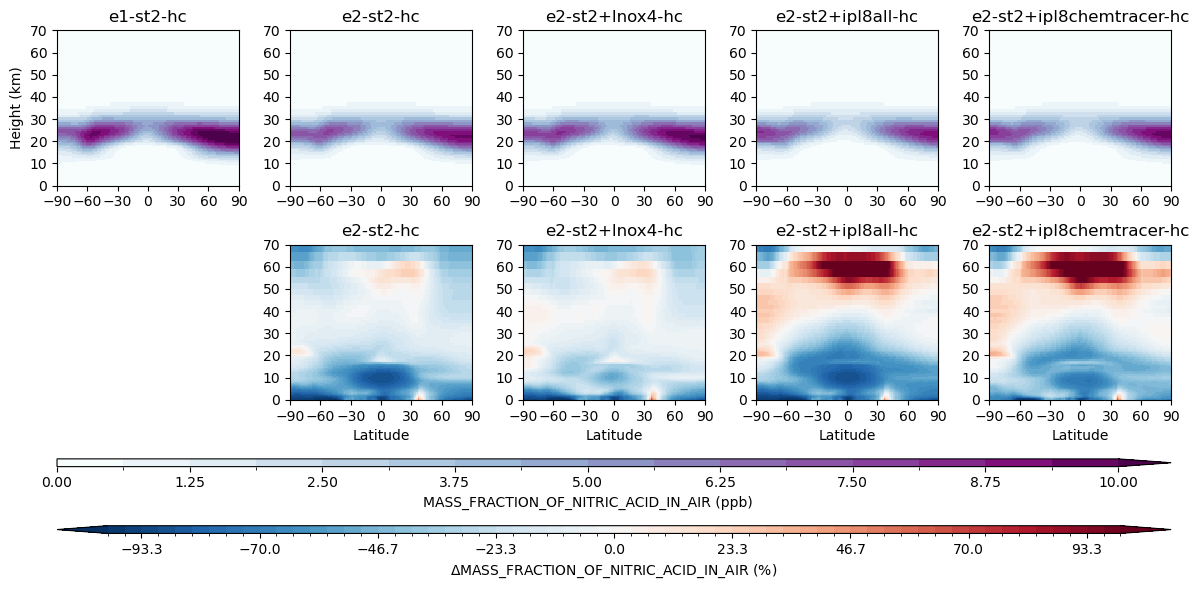

In [63]:
fig, ax = plot_zonal_mean(
    zonal_mean_ppb=zonal_mean_ppb,
    species="mass_fraction_of_nitric_acid_in_air",
    vmax=10,
    diff_vmax=100,
)